<a href="https://colab.research.google.com/github/yasminemejrissi/ml_project/blob/main/ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install faker
!pip install pymongo
!pip install matplotlib
!pip install streamlit

In [2]:
import pandas as pd
from faker import Faker
import pymongo
import matplotlib.pyplot as plt
import streamlit as st
import random
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import importlib.util
import sys

module_name = "config"
file_path = "/content/config.py"

spec = importlib.util.spec_from_file_location(module_name, file_path)
config = importlib.util.module_from_spec(spec)
sys.modules[module_name] = config
spec.loader.exec_module(config)



In [4]:
from config import uri_mongo
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
client = MongoClient(uri_mongo,server_api=ServerApi('1'))

In [5]:
fake=Faker() #Generate fake data
db=client["ecommerce"] #Select 'ecommerce' database
clients_col=db["clients"] #Collection for clients
commandes_col=db["commandes"] #Collection for orders

In [6]:
clients_col.delete_many({})
commandes_col.delete_many({})

DeleteResult({'n': 11037, 'electionId': ObjectId('7fffffff0000000000000038'), 'opTime': {'ts': Timestamp(1746429089, 562), 't': 56}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1746429089, 562), 'signature': {'hash': b'a\x88*\x17\xce\x99\xfa\xdb\x08j:\x95a\xf1\xaf\xe6L\xe5,\xa6', 'keyId': 7464295776219299841}}, 'operationTime': Timestamp(1746429089, 562)}, acknowledged=True)

In [7]:
#Générer les produits
# Generate sample product data (name, category, price)

produits=[
    {"nom":"T-shirt","catégorie":"Vêtements","prix":20},
    {"nom":"Jean","catégorie":"Vêtements","prix":45},
    {"nom":"Basket","catégorie":"Chaussures","prix":70},
    {"nom":"Bracelet","catégorie":"Accessoires","prix":18},
    {"nom":"Collier","catégorie":"Accessoires","prix":25},
    {"nom":"Sac à main", "catégorie":"Bagagerie", "prix":20},
    {"nom":"Sac à dos", "catégorie":"Bagagerie", "prix":30},
    {"nom":"Montre", "catégorie":"Accessoires", "prix":90},
    {"nom":"Full Korean skincare", "catégorie":"Beauté", "prix":120},
    {"nom":"Chargeur", "catégorie":"Informatique","prix":15},

]

In [8]:
#Generate and insert 100 fake clients into the database

clients=[]
for i in range(100):
  client={
  "nom":fake.last_name(),
  "prenom":fake.first_name(),
  "adresse":fake.address(),
  "ville":fake.city(),
  "code_postal":fake.postcode(),
  "pays":fake.country(),
  "email":fake.email(),
  "telephone":fake.phone_number(),
  }
  client_id=clients_col.insert_one(client).inserted_id
  clients.append({"_id": client_id, **client})

In [9]:
commandes=[]
moyen_paiement=["Carte bancaire", "Paypal", "Virement", "Apple Pay"]
code_promo=[None,"WELCOME10","SALES20","FREESHIP"]

# Generate 2000 fake orders
for i in range(2000):
  client=random.choice(clients)
  nb_produits=random.randint(1, len(produits))
  produit_commande=[]
  montant_totale=0
  for j in range(nb_produits):
    produit=random.choice(produits)
    quantite= random.randint(1,5)
    prix=produit["prix"]
    montant=round(prix*quantite,2)
    produit_commande.append({
        "nom":produit["nom"],
        "prix_unitaire":prix,
        "quantite":quantite,
        "montant":montant
    })
    montant_totale+=montant
    date=fake.date_between(start_date='-6M', end_date='today')
    commande={
        "client_id":client["_id"],
        "date":date.isoformat(),
        "email":client["email"],
        "pays":client["pays"],
        "produits":produit_commande,
        "moyen_paiement":random.choice(moyen_paiement),
        "code_promo":random.choice(code_promo),
        "montant_totale":montant_totale

    }
    commandes.append(commande)

# Insert all orders into the database
commandes_col.insert_many(commandes)

#Print first 3 orders for verification

for doc in commandes_col.find().limit(3):
   print(doc)


{'_id': ObjectId('681864af84fd19d82ba80852'), 'client_id': ObjectId('681864ad84fd19d82ba80844'), 'date': '2024-12-28', 'email': 'kirkkim@example.com', 'pays': 'Ecuador', 'produits': [{'nom': 'Jean', 'prix_unitaire': 45, 'quantite': 4, 'montant': 180}, {'nom': 'Sac à dos', 'prix_unitaire': 30, 'quantite': 1, 'montant': 30}], 'moyen_paiement': 'Paypal', 'code_promo': 'SALES20', 'montant_totale': 180}
{'_id': ObjectId('681864af84fd19d82ba80853'), 'client_id': ObjectId('681864ad84fd19d82ba80844'), 'date': '2025-01-14', 'email': 'kirkkim@example.com', 'pays': 'Ecuador', 'produits': [{'nom': 'Jean', 'prix_unitaire': 45, 'quantite': 4, 'montant': 180}, {'nom': 'Sac à dos', 'prix_unitaire': 30, 'quantite': 1, 'montant': 30}], 'moyen_paiement': 'Apple Pay', 'code_promo': 'FREESHIP', 'montant_totale': 210}
{'_id': ObjectId('681864af84fd19d82ba80854'), 'client_id': ObjectId('681864a784fd19d82ba80802'), 'date': '2024-11-23', 'email': 'richardsantos@example.net', 'pays': 'Taiwan', 'produits': [{'no

In [10]:
#KPIs
#Chiffres d'affaires
#Total revenue and order count by country

pipeline = [
    {
        "$group": {
            "_id": "$pays",
            "chiffre_affaires": { "$sum": "$montant_totale" },
            "nb_commandes": { "$sum": 1 }
        }
    },
    {
        "$sort": { "chiffre_affaires": -1 }
    }
]

resultat = list(commandes_col.aggregate(pipeline))

for doc in resultat:
    print(f"{doc['_id']} : {round(doc['chiffre_affaires'], 2)} € sur {doc['nb_commandes']} commandes.")

French Southern Territories : 195652 € sur 314 commandes.
Holy See (Vatican City State) : 165107 € sur 306 commandes.
Tuvalu : 149614 € sur 267 commandes.
Iran : 143998 € sur 278 commandes.
Egypt : 130195 € sur 257 commandes.
Paraguay : 124352 € sur 220 commandes.
Taiwan : 116501 € sur 172 commandes.
Chad : 110728 € sur 197 commandes.
Germany : 109426 € sur 207 commandes.
Guadeloupe : 108845 € sur 159 commandes.
Iceland : 108379 € sur 214 commandes.
Albania : 107380 € sur 217 commandes.
Jersey : 104195 € sur 171 commandes.
Monaco : 102380 € sur 209 commandes.
Zimbabwe : 99840 € sur 167 commandes.
Western Sahara : 96798 € sur 139 commandes.
Macao : 94443 € sur 169 commandes.
Bahrain : 92882 € sur 157 commandes.
Brunei Darussalam : 91821 € sur 156 commandes.
Spain : 89985 € sur 146 commandes.
Bangladesh : 89666 € sur 133 commandes.
Kuwait : 89147 € sur 161 commandes.
Cocos (Keeling) Islands : 85902 € sur 133 commandes.
Syrian Arab Republic : 85509 € sur 125 commandes.
Gabon : 84490 € sur

In [11]:
#Top 10 clients

pipeline=[
    {
        "$group":{
            "_id":"$client_id",
            "montant_total":{"$sum":"$montant_totale"},
            "nb_commandes":{"$sum":1}
        }
    },
    {
        "$sort":{"montant_total":-1}
    },
    {"$limit":10},
    {
        "$lookup":{
            "from":"clients",
            "localField":"_id",
            "foreignField":"_id",
            "as":"client"
    }},
    {"$unwind":"$client"},
    {"$project":{
        "nom":"$client.nom",
        "prenom":"$client.prenom",
        "email": "$client.email",
        "adresse":"$client.adresse",
        "ville":"$client.ville",
        "pays":"$client.pays",
        "chiffre_affaires":"$montant_total",
        "nb_commandes":"$nb_commandes"
    }}
]
top_clients=list(commandes_col.aggregate(pipeline))
for client in top_clients:
  print(f"{client['nom']} {client['prenom']} ({client['email']}) - {client['adresse']}, {client['ville']}, {client['pays']} - {round(client['chiffre_affaires'],2)} EUR sur {client['nb_commandes']} commandes.")


Tate Kevin (richardsantos@example.net) - 2244 King Tunnel
Gonzalezport, NH 77302, Jamesport, Taiwan - 116501 EUR sur 172 commandes.
Perez Melanie (vhahn@example.net) - 057 Fred Drive
Lake Kimberly, WA 17548, Phillipston, Guadeloupe - 108845 EUR sur 159 commandes.
Fernandez Stephen (opowers@example.org) - 5312 Amanda Trace Suite 158
Bradyside, DC 79316, West Steve, Jersey - 104195 EUR sur 171 commandes.
Jackson Jessica (pamelajohnson@example.org) - 667 Lopez Burg Apt. 106
Nelsonbury, WA 96810, Butlerberg, Zimbabwe - 99840 EUR sur 167 commandes.
Jones Justin (jmorales@example.com) - PSC 8905, Box 4053
APO AP 03151, Lake Stephen, Western Sahara - 96798 EUR sur 139 commandes.
George Russell (kimberly70@example.com) - 472 Jones Ports
East Matthewfort, WV 19982, Garciafort, Macao - 94443 EUR sur 169 commandes.
Welch Sarah (richardsonamy@example.org) - 62215 Klein Meadows Suite 625
Susantown, GU 57756, West Sandraview, Bahrain - 92882 EUR sur 157 commandes.
Henry Robert (mmorrow@example.net) 

In [12]:
#Regrouper par pays
#Group by country

pipeline=[
    {
        "$group":{
            "_id":"$pays",
            "chiffre_affaires":{"$sum":"$montant_totale"},
            "nb_commandes":{"$sum":1}
        }
    },
    {

          "$sort":{"chiffre_affaires":-1}

    }
]
resultat=list(commandes_col.aggregate(pipeline))
for doc in commandes_col.find().limit(5):
  print(doc["pays"])
for doc in resultat:
  if doc['chiffre_affaires'] is not None:
    print(f"{doc['_id']}:{doc['chiffre_affaires']}€ sur {doc['nb_commandes']} commandes")
  else:
    print(f"{doc['_id']}: Aucun chiffre d'affaires")

Ecuador
Ecuador
Taiwan
Taiwan
Taiwan
French Southern Territories:195652€ sur 314 commandes
Holy See (Vatican City State):165107€ sur 306 commandes
Tuvalu:149614€ sur 267 commandes
Iran:143998€ sur 278 commandes
Egypt:130195€ sur 257 commandes
Paraguay:124352€ sur 220 commandes
Taiwan:116501€ sur 172 commandes
Chad:110728€ sur 197 commandes
Germany:109426€ sur 207 commandes
Guadeloupe:108845€ sur 159 commandes
Iceland:108379€ sur 214 commandes
Albania:107380€ sur 217 commandes
Jersey:104195€ sur 171 commandes
Monaco:102380€ sur 209 commandes
Zimbabwe:99840€ sur 167 commandes
Western Sahara:96798€ sur 139 commandes
Macao:94443€ sur 169 commandes
Bahrain:92882€ sur 157 commandes
Brunei Darussalam:91821€ sur 156 commandes
Spain:89985€ sur 146 commandes
Bangladesh:89666€ sur 133 commandes
Kuwait:89147€ sur 161 commandes
Cocos (Keeling) Islands:85902€ sur 133 commandes
Syrian Arab Republic:85509€ sur 125 commandes
Gabon:84490€ sur 130 commandes
Central African Republic:84482€ sur 135 command

In [13]:
#panier moyen
#Average basket value

pipeline=[
    {
          "$group":{
              "_id":None,
              "total_montant":{"$sum":"$montant_totale"},
              "total_commandes":{"$sum":1}
          }
      },
      {
          "$project":{
              "_id":0,
              "panier_moyen":{"$divide": ["$total_montant","$total_commandes"]
              },
              "total_montant":1,
              "total_commandes":1
          }
      }
]

resultat = list(commandes_col.aggregate(pipeline))

if resultat:  # Vérifie qu'il y a au moins un document
    panier_moyen = round(resultat[0]["panier_moyen"], 2)
    print(f"Le panier moyen est : {panier_moyen} EUR")
else:
    print("Aucune commande trouvée.")

Le panier moyen est : 554.99 EUR


In [14]:
#panier moyen par mois
# Average basket value per month

pipeline=[
    {
        "$group":{
            "_id": {"$substr":["$date",0,7]},
            "nb_commandes": {"$sum":1},
            "chiffre_affaires":{"$sum":"$montant_totale"},
        }
    },
    {
        "$project":{
            "nb_commandes":1,
            "chiffre_affaires":1,
            "panier_moyen":{"$divide":["$chiffre_affaires","$nb_commandes"]}
        }
    },
    {
        "$sort":{"_id":1}
    }
]
resultat=list(commandes_col.aggregate(pipeline))
for ligne in resultat:
  print(f"{ligne['_id']} : {ligne['nb_commandes']} commandes - {round(ligne['chiffre_affaires'],2)} EUR - panier moyen {round(ligne['panier_moyen'],2)}")

#dataframe pour panier moyen et affichage

2024-11 : 1708 commandes - 956410 EUR - panier moyen 559.96
2024-12 : 1903 commandes - 1061753 EUR - panier moyen 557.94
2025-01 : 1891 commandes - 1010619 EUR - panier moyen 534.44
2025-02 : 1753 commandes - 974097 EUR - panier moyen 555.67
2025-03 : 1823 commandes - 1013637 EUR - panier moyen 556.03
2025-04 : 1876 commandes - 1054373 EUR - panier moyen 562.03
2025-05 : 237 commandes - 140002 EUR - panier moyen 590.73


In [15]:
#Segmentation des clients
# Customer segmentation

pipeline=[
    {
        "$group":{
            "_id":"$client_id",
            "chiffre_affaires":{"$sum":"$montant_totale"},
            "nb_commandes":{"$sum":1},
            "nb_commandes_promos":{
                "$sum":{
                    "$cond":[{"$ne":["$code_promo",None]},1,0]}} # Count 1 if promo code is used, else 0
        }
    },
    {
        "$project":{
            "nb_commandes":1,
            "chiffre_affaires":1,
            "code_promo":1,
            "panier_moyen":{"$round":[{"$divide":["$chiffre_affaires","$nb_commandes"]},2]},
            "ratio_code_promos": {"$round":[{"$divide":["$nb_commandes_promos","$nb_commandes"]},2]
        }}
    },
    {
        "$lookup":{
            "from":"clients",
            "localField":"_id",
            "foreignField":"_id",
            "as":"client"
        }
    },
    {
        "$unwind":"$client"
    },
    #Display
    {
        "$project":{
            "client_id":"$_id",
            "nom":"$client.nom",
            "prenom":"$client.prenom",
            "pays":"$client.pays",
            "email":"$client.email",
            "chiffre_affaires":1,
            "nb_commandes":1,
            "panier_moyen":1,
            "ratio_code_promos":1
        }
    }
]

resultat = list(commandes_col.aggregate(pipeline))
df_comportement=pd.DataFrame(resultat)
colonnes=["client_id","nom","prenom","pays","email","chiffre_affaires","nb_commandes","panier_moyen","ratio_code_promos"]
df=df_comportement[colonnes]
df_clients = pd.DataFrame(resultat)

print(df["chiffre_affaires"].describe())
print(df["nb_commandes"].describe())
print(df["panier_moyen"].describe())
print(df["ratio_code_promos"].describe())

count       100.000000
mean      62108.910000
std       19515.754221
min       23961.000000
25%       46703.250000
50%       57792.500000
75%       76483.500000
max      116501.000000
Name: chiffre_affaires, dtype: float64
count    100.000000
mean     111.910000
std       29.113534
min       49.000000
25%       92.500000
50%      113.000000
75%      130.500000
max      172.000000
Name: nb_commandes, dtype: float64
count    100.000000
mean     552.182300
std       73.695074
min      404.140000
25%      488.925000
50%      552.020000
75%      609.855000
max      696.390000
Name: panier_moyen, dtype: float64
count    100.000000
mean       0.746700
std        0.044177
min        0.610000
25%        0.720000
50%        0.750000
75%        0.770000
max        0.860000
Name: ratio_code_promos, dtype: float64


In [16]:
#Segmentation profil
# Customer profile segmentation

df = pd.DataFrame(resultat)

def profiler(row):
  if row["chiffre_affaires"]>=1000 and row["nb_commandes"]>=130:
    return "VIP"
  if row["ratio_code_promos"]>=0.765 and row["nb_commandes"]>=115:
    return "Promo addict"
  if row["nb_commandes"]>=90:
    return "Régulier"
  else:
    return "Occasionnel"

df["profil"]=df.apply(profiler, axis=1)
df.head(10)

#Display
df[["client_id", "chiffre_affaires", "nb_commandes", "profil"]].head(10)

,client_id,chiffre_affaires,nb_commandes,profil
0,681864a684fd19d82ba807ff,80168,125,Régulier
1,681864a784fd19d82ba80808,53404,126,Régulier
2,681864ad84fd19d82ba80843,41008,67,Occasionnel
3,681864ae84fd19d82ba8084c,80329,140,VIP
4,681864ab84fd19d82ba80829,59411,117,Promo addict
5,681864a584fd19d82ba807f3,49473,93,Régulier
6,681864a784fd19d82ba80801,46733,96,Régulier
7,681864a684fd19d82ba807fa,64040,98,Régulier
8,681864ac84fd19d82ba8083b,84490,130,VIP
9,681864a584fd19d82ba807f1,72044,113,Régulier


In [17]:
#Dernier achat:
# Last purchase date per client:

pipeline=[
    {
        "$group":{
            "_id":"$client_id",
            "dernier_achat":{"$max":"$date"}
        }
    }
]
resultat = list(commandes_col.aggregate(pipeline))

df_dates=pd.DataFrame(resultat)
df_dates.rename(columns={"_id":"client_id"}, inplace=True)

#Nombre de jour depuis le dernier achat
# Number of days since last purchase
today = pd.Timestamp(datetime.today())
df_dates["dernier_achat"]=pd.to_datetime(df_dates["dernier_achat"])
df_dates["duree_dernier_achat"]=today-df_dates["dernier_achat"]
df_dates

,client_id,dernier_achat,duree_dernier_achat
0,681864a884fd19d82ba8080c,2025-05-04,1 days 07:11:53.427449
1,681864ab84fd19d82ba8082e,2025-05-02,3 days 07:11:53.427449
2,681864a684fd19d82ba807f9,2025-05-03,2 days 07:11:53.427449
3,681864ae84fd19d82ba80851,2025-05-04,1 days 07:11:53.427449
4,681864a984fd19d82ba8081b,2025-05-04,1 days 07:11:53.427449
...,...,...,...
95,681864ab84fd19d82ba8082d,2025-05-03,2 days 07:11:53.427449
96,681864ad84fd19d82ba8083e,2025-05-02,3 days 07:11:53.427449
97,681864aa84fd19d82ba8081f,2025-05-02,3 days 07:11:53.427449
98,681864a884fd19d82ba8080f,2025-05-04,1 days 07:11:53.427449


In [18]:
#Compter produits distincts achetés par client
#Count distinct products purchased per client

pipeline=[
    {"$unwind":"$produits"},
    {
        "$group":{
          "_id":{"client":"$client_id","produit":"$produits.nom"}
      }
    },
    {
        "$group": {
            "_id": "$_id.client",
            "produits_uniques": { "$addToSet": "$_id.produit" }
        }
    },
    {
        "$project": {
            "nb_produits_distincts": { "$size": "$produits_uniques" }
        }
    }
]

resultat = list(commandes_col.aggregate(pipeline))
df_produits = pd.DataFrame(resultat)
df_produits.rename(columns={"_id": "client_id"}, inplace=True)
df_produits.head()

,client_id,nb_produits_distincts
0,681864ad84fd19d82ba80842,10
1,681864ac84fd19d82ba80836,10
2,681864ab84fd19d82ba80829,10
3,681864ae84fd19d82ba80849,10
4,681864ad84fd19d82ba80846,10


In [19]:
client_id = commandes_col.find_one({}, {"client_id": 1})["client_id"]

# Récupère tous les produits commandés par ce client
# Retrieve all products ordered by this client

produits_commandes = set()
for commande in commandes_col.find({"client_id": client_id}):
    for p in commande["produits"]:
        produits_commandes.add(p["nom"])

print("Produits achetés :", produits_commandes)
print("Total distincts :", len(produits_commandes))


Produits achetés : {'Montre', 'Collier', 'Sac à dos', 'Basket', 'Jean', 'Chargeur', 'T-shirt', 'Sac à main', 'Full Korean skincare', 'Bracelet'}
Total distincts : 10


In [20]:
# Merge client data with last purchase dates (inner join, like SQL)
df_ml = pd.merge(df_clients, df_dates, on='client_id', how='inner') #similaire join sql; how='inner' pour garder uniquement les clients qui sont dans les deux DataFrames
df_ml.head()

,_id,chiffre_affaires,nb_commandes,panier_moyen,ratio_code_promos,client_id,nom,prenom,pays,email,dernier_achat,duree_dernier_achat
0,681864a684fd19d82ba807ff,80168,125,641.34,0.66,681864a684fd19d82ba807ff,Armstrong,Audrey,Somalia,turnersteven@example.net,2025-05-03,2 days 07:11:53.427449
1,681864a784fd19d82ba80808,53404,126,423.84,0.74,681864a784fd19d82ba80808,Carter,Lori,Nicaragua,ythompson@example.org,2025-05-03,2 days 07:11:53.427449
2,681864ad84fd19d82ba80843,41008,67,612.06,0.76,681864ad84fd19d82ba80843,Baker,Tyler,Germany,bethany39@example.net,2025-05-03,2 days 07:11:53.427449
3,681864ae84fd19d82ba8084c,80329,140,573.78,0.79,681864ae84fd19d82ba8084c,White,Amanda,Bhutan,laura99@example.org,2025-05-02,3 days 07:11:53.427449
4,681864ab84fd19d82ba80829,59411,117,507.79,0.80,681864ab84fd19d82ba80829,King,Sarah,Belarus,htodd@example.org,2025-05-04,1 days 07:11:53.427449


In [21]:
# Churn (binary satisfaction): no order in the last 4+ days (due to data range)

today = pd.Timestamp(datetime.today())
df_ml["duree_dernier_achat"] = (today - df_ml["dernier_achat"]).dt.days
df_ml["churn"]=(df_ml["duree_dernier_achat"]>4).astype(int)
df_ml[["client_id", "duree_dernier_achat", "churn"]].head(50)


,client_id,duree_dernier_achat,churn
0,681864a684fd19d82ba807ff,2,0
1,681864a784fd19d82ba80808,2,0
2,681864ad84fd19d82ba80843,2,0
3,681864ae84fd19d82ba8084c,3,0
4,681864ab84fd19d82ba80829,1,0
5,681864a584fd19d82ba807f3,2,0
6,681864a784fd19d82ba80801,2,0
7,681864a684fd19d82ba807fa,2,0
8,681864ac84fd19d82ba8083b,1,0
9,681864a584fd19d82ba807f1,5,1


In [22]:
# Drop target and identifier columns to create feature matrix
X = df_ml.drop(columns=["churn", "client_id", "_id"], errors='ignore') #avoid errors if columns are missing
y = df_ml["churn"]


In [23]:
#Séparer les variables explicatives et la cible (qui est la colonne churn)
# Separate features (X) and target variable (y)

from sklearn.model_selection import train_test_split

X = df_ml.drop(columns=["churn", "client_id", "email", "nom", "prenom", "pays"], errors="ignore")
y = df_ml["churn"]

# Séparation entre train et test sets (80% - 20%)
# Split the data into training and testing sets (80% train / 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Taille du train :", X_train.shape)
print("Taille du test :", X_test.shape)


Taille du train : (80, 7)
Taille du test : (20, 7)


In [24]:
# Check data types of features
print(X.dtypes)


_id                            object
chiffre_affaires                int64
nb_commandes                    int64
panier_moyen                  float64
ratio_code_promos             float64
dernier_achat          datetime64[ns]
duree_dernier_achat             int64
dtype: object


In [25]:
# On garde uniquement les colonnes numériques
# Keep only numerical feature columns
X = df_ml.drop(columns=["_id", "dernier_achat"], errors="ignore")
X = X.select_dtypes(include=["int64", "float64"])

# Define target variable
y = df_ml["churn"]


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [27]:
from sklearn.ensemble import RandomForestClassifier
# Split data into training and testing sets (80/20)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


In [28]:
#Utilisation modèle de classification
#Train and evaluate a classification model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

#Modèle
#Initialize and train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

#Prédictions
#Predict on test set
y_pred = rf.predict(X_test)

#Résultats
#Evaluation metrics
print("Évaluation Random Forest :")
print(classification_report(y_test, y_pred))

#Random Forest is chosen for its robustness, ability to handle complex feature interactions,
#and built-in feature importance evaluation.

Évaluation Random Forest :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         1

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



**Classe 0 (clients fidèles)**
*Précision* : 1.00 → Tous ceux prédits comme fidèles le sont vraiment

*Recall* : 1.00 → Tous les vrais fidèles ont été détectés

*Support*: 19 → Il y avait 19 clients fidèles dans le test


**Classe 1 (clients churnés)**
*Précision* : 1.00 → Le seul client prédit comme churné l’était vraiment

*Recall* : 1.00 → Le seul churn réel a bien été trouvé

*Support* : 1 → Il n’y avait qu’un seul churn dans le test

📊 **Global**

**Métrique	Interprétation**

*accuracy* = 1.00	100% de bonnes prédictions sur les 20 cas

*macro avg* = 1.00	Moyenne entre les classes sans tenir compte du déséquilibre

*weighted avg* = 1.00	Moyenne pondérée par le nombre de cas dans chaque classe

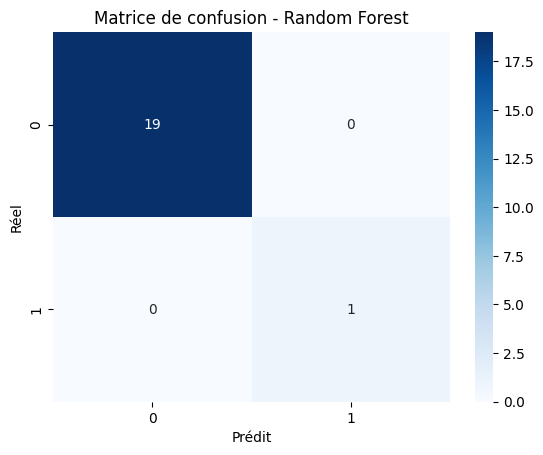

In [29]:
#Plot confusion matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Random Forest")
plt.show()
